In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [107]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [30]:
train = pd.read_csv('titanic_train.csv') #Reading the training data 
test = pd.read_csv('titanic_test.csv') #Reading the test data 
sample = pd.read_csv('gender_submission.csv') #Reading sample submission

In [26]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Exploratory Data Analysis

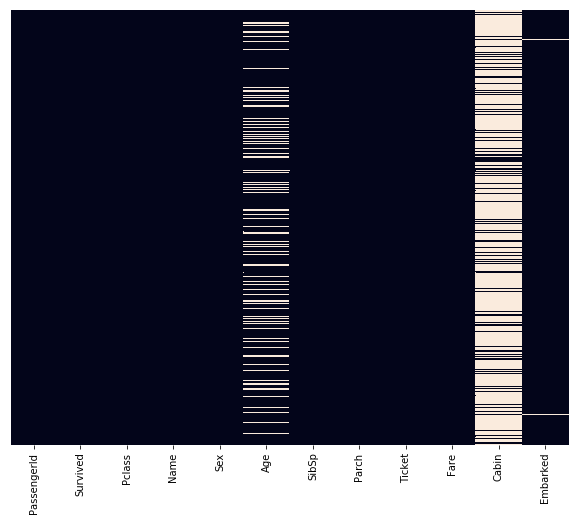

In [28]:
#checking the missing values using heatmap 
plt.figure(figsize=(10,8))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False) 

The white lines represent the missing data in the respective columns. The number of missing values in 'Age' is relatively lesser than the values in 'Cabin' column. Hence the missing values of Age can be filled with some form of imputation. But there are too many missing values in the Cabin column for the columns to be valuable to us, and thus the Cabin column can be dropped. The 'Embarked' column has two missing values that can be filled easily.

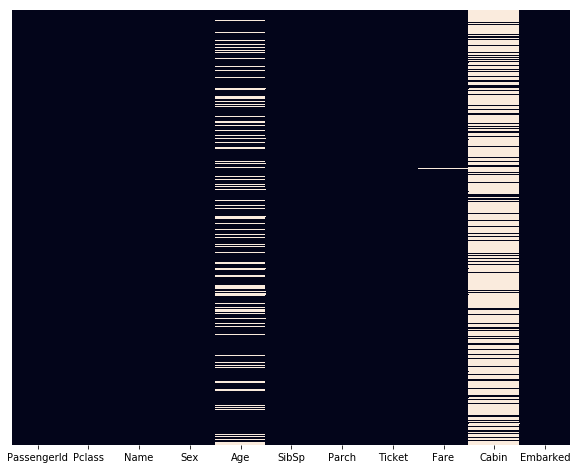

In [113]:
#checking the missing values using heatmap 
plt.figure(figsize=(10,8))
sns.heatmap(test.isnull(),yticklabels=False,cbar=False)

Same is the case with testing data. Just that a value of 'Fare' column is missing. (And no missing values in 'Embarked' column)

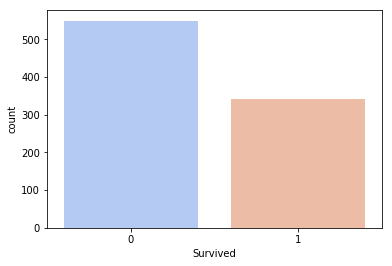

In [29]:
sns.countplot(x='Survived', data=train, palette='coolwarm')

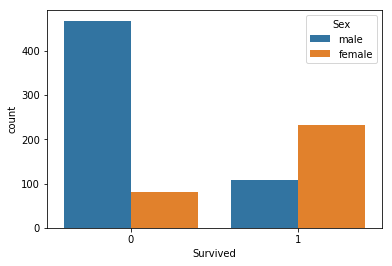

In [13]:
sns.countplot(x='Survived',hue='Sex', data=train)

The countplot above shows that the men were more likely to not survive than women.

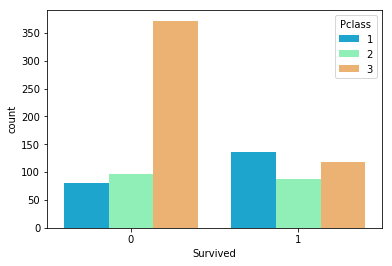

In [15]:
sns.countplot(x='Survived',hue='Pclass',data=train, palette="rainbow")

This plot shows that the passengers in class 3 were far more less likely to survive than the other classes. Also, people of class 1 had a relatively higher survival rate.

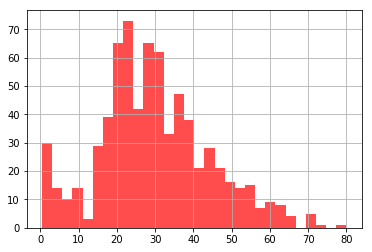

In [20]:
train['Age'].hist(bins=30,color='red',alpha=0.7)

The histogram goes to show that most of the people on the ship were around 20-25 years of age.

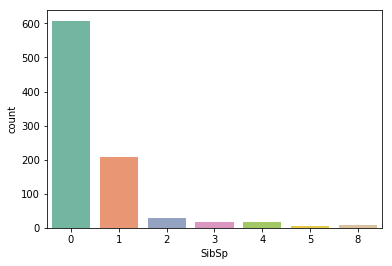

In [22]:
sns.countplot(x='SibSp',data=train, palette='Set2')

The plot above indicates that most of the passengers were alone i.e. with no siblings/spouses on the ship.

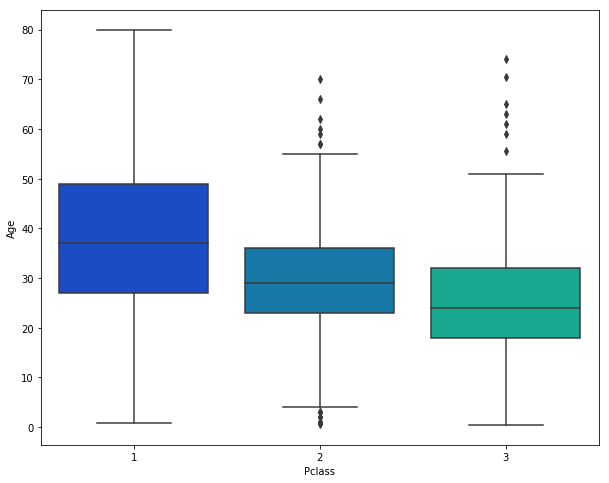

In [31]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

The boxplot above shows that the passengers in higher classes tend to be relatively older. Hence it seems logical to fill the 'Age' values using the average ages for each Pclass. 

# Data Cleaning

In [33]:
train.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [35]:
def fill_age(row):
    age = row[0]
    pclass = row[1]
    
    if pd.isnull(age):
        
        if pclass == 1:
            return 38
        
        if pclass == 2:
            return 30
        
        if pclass == 3:
            return 25
        
    else:
        return age

In [37]:
train['Age'] = train[['Age','Pclass']].apply(fill_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(fill_age,axis=1)

In [38]:
#Since 'Cabin' column has a lot of missing values, we drop it.
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

In [45]:
#We fill the missing 'Embarked' values with the mode of the column.
mode_embarked = train['Embarked'].dropna().mode()[0]
train['Embarked'] = train['Embarked'].fillna(mode_embarked)

In [118]:
#We fill the missing 'Fare' values in the test set using the median of the column.
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

Now lets check the heatmap again.

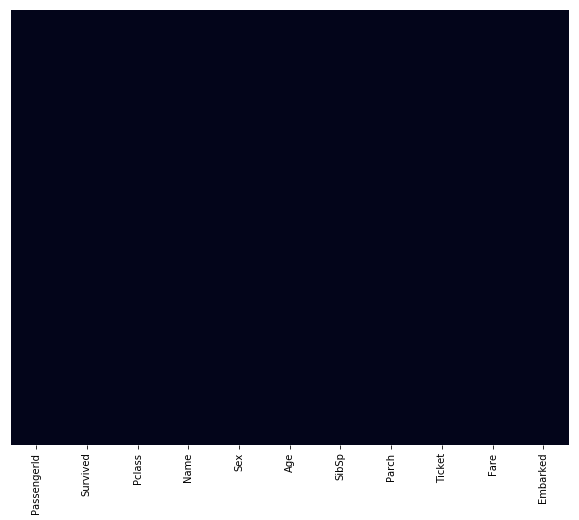

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

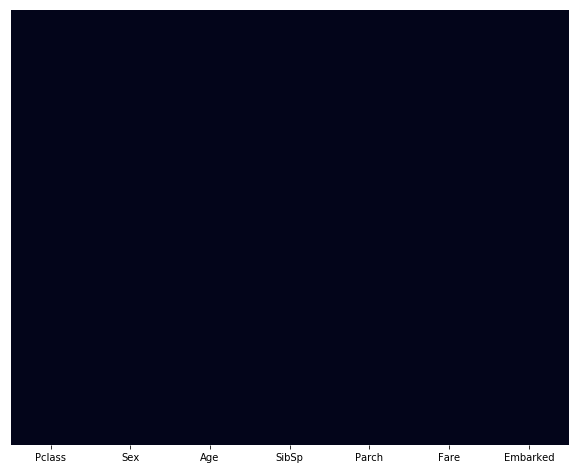

In [120]:
plt.figure(figsize=(10,8))
sns.heatmap(test.isnull(),yticklabels=False,cbar=False)

There are no white lines in the heatmap of both training and testing data, which indicates there are no missing values.

In [47]:
train['Name'].nunique()

891

In [59]:
train['PassengerId'].nunique()

891

The 'Name' and 'PassengerId' column values are unique for each row, hence doesn't provide any valuable information. Similiarly the 'Ticket' column values only indicate the ticket number of each passenger which does not provide any insight on the chances of survival. Hence, these columns are dropped.  

In [49]:
train.drop(['Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
test.drop(['Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

We need to convert 'Sex' and 'Embarked' values to numeric values so that the training data can be fed to the learning algorithms.

In [52]:
le = LabelEncoder()

In [55]:
train['Sex'] = le.fit_transform(train['Sex'])
train['Embarked'] = le.fit_transform(train['Embarked'])

In [117]:
test['Sex'] = le.fit_transform(test['Sex'])
test['Embarked'] = le.fit_transform(test['Embarked'])

In [121]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


In [61]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


Since all the values of the training data are numeric, it is ready to be fed into learning algorithm

# Building and Evaluating Models

We split the the training data into training and test data to evaluate the models.

In [62]:
X = train.drop('Survived',axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

## k-Nearest Neighbors classifier

In [75]:
#Standard scaling the data before KNN classification
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled = pd.DataFrame(data=X_scaled, columns=X_train.columns.values)

In [84]:
#Using the elbow method to find the best k value
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_scaled,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0,0.5,'Error Rate')

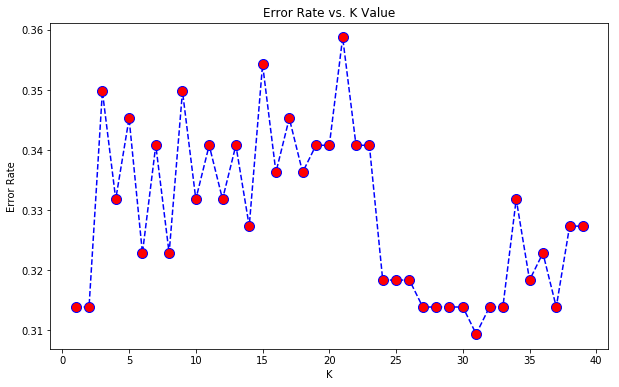

In [85]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [89]:
knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(X_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=31, p=2,
           weights='uniform')

In [90]:
predictKNN = knn.predict(X_test) 

In [91]:
#Evaluating the model
print('Confusion Matrix: \n')
print(confusion_matrix(y_test,predictKNN))
print('\nClassification Report:\n')
print(classification_report(y_test,predictKNN))

Confusion Matrix: 

[[99 28]
 [41 55]]

Classification Report:

             precision    recall  f1-score   support

          0       0.71      0.78      0.74       127
          1       0.66      0.57      0.61        96

avg / total       0.69      0.69      0.69       223



## Naive Bayes Classifier

In [93]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
predictNB = gaussian.predict(X_test)

In [97]:
#Evaluating the model
print('Confusion Matrix: \n')
print(confusion_matrix(y_test,predictNB))
print('\nClassification Report:\n')
print(classification_report(y_test,predictNB))

Confusion Matrix: 

[[103  24]
 [ 29  67]]

Classification Report:

             precision    recall  f1-score   support

          0       0.78      0.81      0.80       127
          1       0.74      0.70      0.72        96

avg / total       0.76      0.76      0.76       223



## Stochastic Gradient Descent

In [105]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
predictSGD = sgd.predict(X_test)

In [98]:
#Evaluating the model
print('Confusion Matrix: \n')
print(confusion_matrix(y_test,predictSGD))
print('\nClassification Report:\n')
print(classification_report(y_test,predictSGD))

Confusion Matrix: 

[[116  11]
 [ 59  37]]

Classification Report:

             precision    recall  f1-score   support

          0       0.66      0.91      0.77       127
          1       0.77      0.39      0.51        96

avg / total       0.71      0.69      0.66       223



## Decision Tree Classifier

In [99]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
predictDT = decision_tree.predict(X_test)

In [100]:
#Evaluating the model
print('Confusion Matrix: \n')
print(confusion_matrix(y_test,predictDT))
print('\nClassification Report:\n')
print(classification_report(y_test,predictDT))

Confusion Matrix: 

[[113  14]
 [ 32  64]]

Classification Report:

             precision    recall  f1-score   support

          0       0.78      0.89      0.83       127
          1       0.82      0.67      0.74        96

avg / total       0.80      0.79      0.79       223



## Random Forest Classifier

In [101]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
predictRF = random_forest.predict(X_test)

In [103]:
#Evaluating the model
print('Confusion Matrix: \n')
print(confusion_matrix(y_test,predictRF))
print('\nClassification Report:\n')
print(classification_report(y_test,predictRF))

Confusion Matrix: 

[[112  15]
 [ 28  68]]

Classification Report:

             precision    recall  f1-score   support

          0       0.80      0.88      0.84       127
          1       0.82      0.71      0.76        96

avg / total       0.81      0.81      0.80       223



## Support Vector Machine

In [108]:
#Using Grid Search to optimize parameters of SVC
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.3s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [109]:
#Best parameters chosen
grid.best_params_

{'C': 100, 'gamma': 0.001}

In [110]:
grid_predictions = grid.predict(X_test)

In [112]:
#Evaluating the model
print('Confusion Matrix: \n')
print(confusion_matrix(y_test,grid_predictions))
print('\nClassification Report:\n')
print(classification_report(y_test,grid_predictions))

Confusion Matrix: 

[[105  22]
 [ 35  61]]

Classification Report:

             precision    recall  f1-score   support

          0       0.75      0.83      0.79       127
          1       0.73      0.64      0.68        96

avg / total       0.74      0.74      0.74       223



#### The best performance is shown by Random Forest Classifier. Hence, we choose that classifier to creat our final submission.

In [124]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X, y)
predictions = RF.predict(test)

In [125]:
submission = pd.DataFrame({
        "PassengerId": sample["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('submission.csv', index=False)